# Genetic Algorithms Primer

Genetic Algorithms borrow inspiration from biological inheritance processes to attempt to solve optimization problems by generating a "population" of possible solutions (chromosomes) from which the most "fit" are selected for mating and mutation. By iterating this process over generations we expect the population to slowly converge upon the most optimum region of our problem-space which would correspond to the solution to the task at hand.

In the following examples we will show some of our package's internal functions for educational purposes but it's worth noting that most users won't be in need to use these methods directly in common applications. 

Let's start by creating a regular-grid landscape with three traps located at coordinates `(0,0)` for a continuous optimization task:

(<Figure size 1000x1000 with 1 Axes>, <AxesSubplot:>)

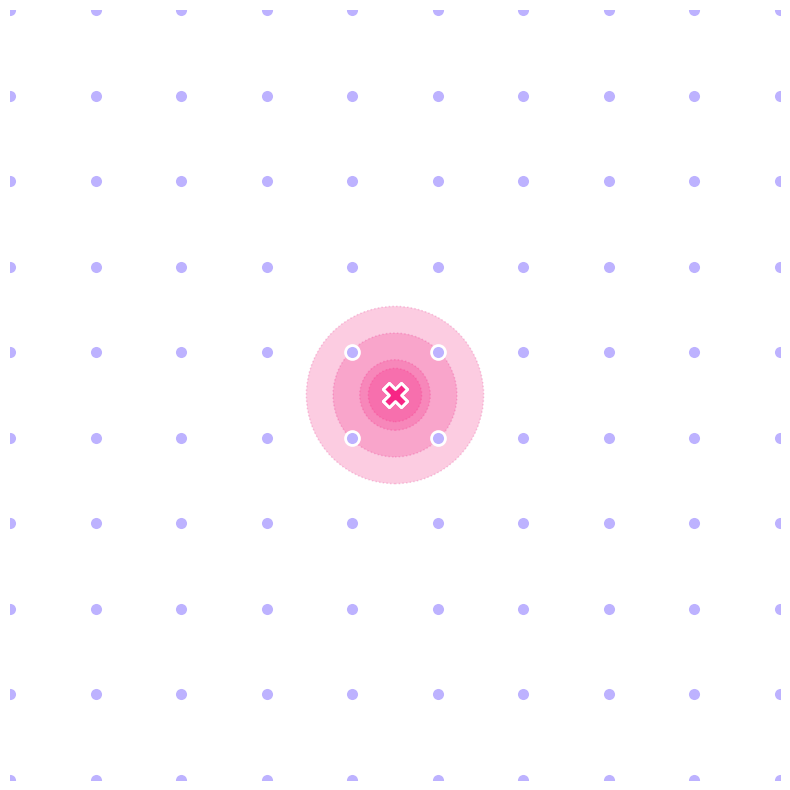

In [1]:
# Fix PROJ path ---------------------------------------------------------------
import os; 
os.environ['PROJ_LIB']=r'/opt/conda/pkgs/proj-9.2.1-ha5fc9e9_0/share/proj'
# Load libraries --------------------------------------------------------------
import numpy as np
import pandas as pd
import MGSurvE as srv
from copy import deepcopy
import matplotlib.pyplot as plt
# Setup data path and ID ------------------------------------------------------
(ID, OUT_PTH) = ('gaPrimer', './out/')
srv.makeFolder(OUT_PTH)
# Generate a Regular Grid -----------------------------------------------------
(PTS_NUM, BOX_SIDE) = (10, (-20, 20))
xy = srv.ptsRegularGrid(PTS_NUM, (BOX_SIDE, BOX_SIDE)).T
points = pd.DataFrame({'x': xy[0], 'y': xy[1], 't': [0]*xy.shape[1]})
# Defining Traps --------------------------------------------------------------
nullTraps = [0, 0, 0]
traps = pd.DataFrame({
    'x': nullTraps, 'y': nullTraps,
    't': nullTraps, 'f': nullTraps
})
tKer = {0: {'kernel': srv.exponentialDecay, 'params': {'A': .5, 'b': .50}}}
# Setting Landscape Object Up -------------------------------------------------
lnd = srv.Landscape(
    points, 
    kernelParams={'params': srv.MEDIUM_MOV_EXP_PARAMS, 'zeroInflation': .25}, 
    traps=traps, trapsKernels=tKer
)
# Plot Results ----------------------------------------------------------------
(fig, ax) = plt.subplots(1, 1, figsize=(10, 10), sharey=False)
lnd.plotSites(fig, ax, size=100)
# lnd.plotMigrationNetwork(fig, ax, alphaMin=.6, lineWidth=25)
lnd.plotTraps(fig, ax)
srv.plotClean(fig, ax, bbox=lnd.landLimits)

## Problem Representation (mapping)

In [MGSurvE](https://github.com/Chipdelmal/MGSurvE) we are trying to solve the question **"Given a heterogeneous environment and a limited number of traps, where should we place the devices?"**, so this is the optimization task we need to map into a genetic algorithm paradigm. To do this, the positions of the traps are encoded into the chromosomes of the populations in pairs of alleles as follows:

![](../../media/fitness.png)

where a chromosome (or individual) would contain the position of the full set of traps. Once we have set the position of our traps we can calculate our fitness metric ($\phi$) by computing the time it would take for a random walker to fall into a trap given the current setup (more on this in the [following section](#fitness)). 

[-15.10362319   9.26127353   7.33978956 -17.12468061   1.17867435
   0.59241651]


(<Figure size 1000x1000 with 1 Axes>,
 <AxesSubplot:title={'center':'Time to Capture: 58.33'}>)

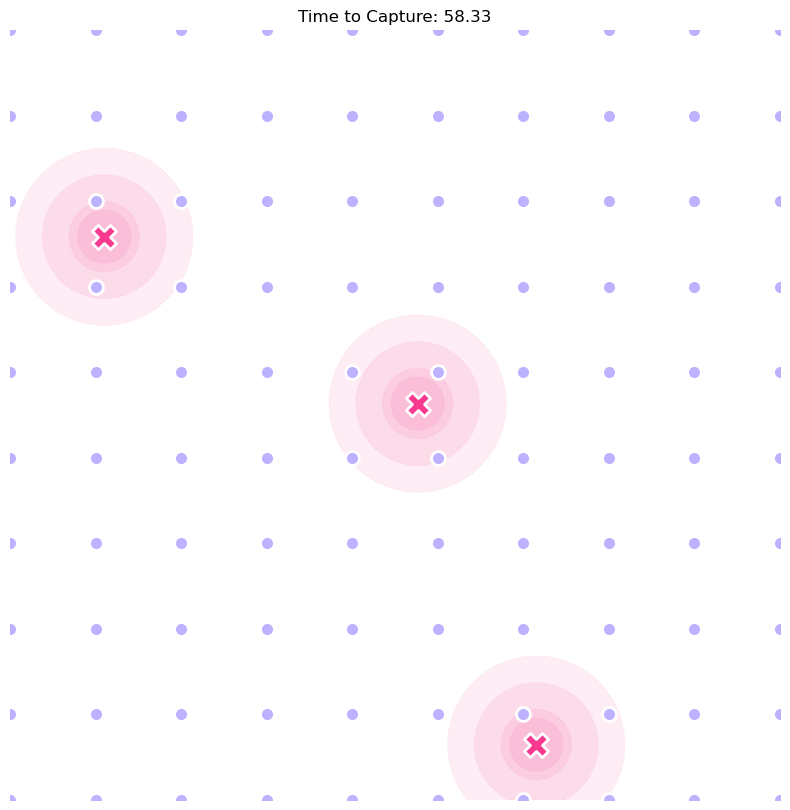

In [2]:
# Initializing a chromosome ---------------------------------------------------
chrom = srv.initChromosome(
    lnd.trapsCoords, 
    srv.genFixedTrapsMask(lnd.trapsFixed), 
    lnd.getBoundingBox()
)
print(chrom)
# Update Landscape ------------------------------------------------------------
lnd.updateTrapsCoords(chrom.reshape(len(nullTraps), 2))
lnd.calcFundamentalMatrix()
fit = lnd.getDaysTillTrapped({'inner': np.sum, 'outer': np.mean})
# Plot Results ----------------------------------------------------------------
(fig, ax) = plt.subplots(1, 1, figsize=(10, 10), sharey=False)
ax.set_title(f'Time to Capture: {fit:.2f}')
lnd.plotSites(fig, ax, size=100)
lnd.plotTraps(fig, ax)
srv.plotClean(fig, ax, bbox=lnd.landLimits)

## Optimization Cycle

A GA traditional optimization cycle follows these steps:

1. [Chromosomes' fitness calculation](#fitness)
2. [Selection of individuals for mating](#selection)
3. [Chromosomes crossover](#crossover)
4. [Population mutation](#mutation)


### Fitness

The fitness (or cost) function is the quantity that guides the artificial evolutionary process, as it is the factor we will try to maximize or minimize. [MGSurvE](https://github.com/Chipdelmal/MGSurvE) computes a summary statistic on the time it would take for a random walker on our network to fall into an absorbing state (a trap) given that it started from any site in our landscape and then attempts to minimize it. Any function that operates on a list of elements can be used for this purpose. For example:

* Using the mean (`np.mean`) or total (`np.sum`) times until trapped usually results in a balanced placement of traps.
* Minimizing the maximum (`np.max`) time it would take for a mosquito to fall into an absorbing state results in the optimization giving more priority to more remote areas of the landscape.
* Other statistics such as the median (`np.median`) or even quantiles could potentially be used as long as they return a single quantity from a list of elements.

![](../../media/fits.png)

Calculating the fitness function is the most computationally-intensive part of the optimization process, as it involves solving [Markov's Fundamental Matrix](https://en.wikipedia.org/wiki/Absorbing_Markov_chain) on each potential solution of our landscape, and as such reducing the number of sites and/or traps usually results in large speedups in the optimization process. 

For all the details and equations of how we compute our base fitness function have a look at our ["Mathematical Formulation"](../more/math.ipynb) document!

In [3]:
# Manually calculating fitness ------------------------------------------------
fitFuns = {'inner': np.sum, 'outer': np.mean}
# Calculate fundamental matrix and fitness ------------------------------------
(tau, sitesN, trapsN) = (lnd.trapsMigration, lnd.pointNumber, lnd.trapsNumber)
F = srv.getFundamentalMatrix(tau, sitesN, trapsN)
daysTillTrapped = np.apply_along_axis(fitFuns['inner'], 1, F)
fitness = fitFuns['outer'](daysTillTrapped)
# Return fitness --------------------------------------------------------------
fitness

58.328181873316225

### Selection

The selection process involves choosing individuals from our pool in order for them to populate the next generation of our evolutionary process (usually in a scheme that favors the fittest individuals). [MGSurvE](https://github.com/Chipdelmal/MGSurvE) is compatible with any of the [DEAP](https://deap.readthedocs.io/en/master/api/tools.html#operators-1) selection operators but uses the [tournament operator](https://deap.readthedocs.io/en/master/api/tools.html#deap.tools.selTournament) by default. In its most basic implementation, this operator randomly takes a defined number of tournament participants (tournament size) from the initial population, selects the fittest from them and repeats the process until we have the desired population size in our next generation.

![](../../media/selection.png)


### Crossover

This step involves taking pairs of chromosomes and "mixing" their alleles to simulate mating processes. [MGSurvE](https://github.com/Chipdelmal/MGSurvE) provides extensions to [DEAP's](https://deap.readthedocs.io/en/master/api/tools.html#operators-1) [cxBlend](https://deap.readthedocs.io/en/master/api/tools.html#deap.tools.cxBlend) crossover operation for continuous optimization, along with [cxUniform](https://deap.readthedocs.io/en/master/api/tools.html#deap.tools.cxUniform) to be used both in continuous and discrete optimization processes. It's worth noting that these two variants are provided for cases in which immovable traps exist, if no fixed traps are present in the landscape any of the  [DEAP's](https://deap.readthedocs.io/en/master/api/tools.html#operators-1) crossover operators can be used.

![](../../media/crossover.png)

In [4]:
# Manually doing a crossover operation ----------------------------------------
fxdTrapsMask = srv.genFixedTrapsMask(lnd.trapsFixed)
(chA, chB) = [
    srv.initChromosome(lnd.trapsCoords, fxdTrapsMask, lnd.getBoundingBox()) 
    for _ in range(2)
]
(pre1, pre2) = (chA.copy(), chB.copy())
(ind1, ind2) = srv.cxBlend(
    chA, chB, 
    [True, False, True, False, False, False], 
    alpha=0.5
)
(ind1, pre1)

(array([ 12.79809757,   0.74711434,  19.27840956, -13.0220358 ,
          9.47297401, -10.5158108 ]),
 array([ 14.13610992,   0.74711434, -14.34807912, -13.0220358 ,
          9.47297401, -10.5158108 ]))

### Mutation

The final step in our evolutionary process is to allow the alleles of selected individuals in our population to "mutate" as to allow for new possible solutions to be generated. Our base [MGSurvE](https://github.com/Chipdelmal/MGSurvE) implementation provides extensions to the [mutGaussian](https://deap.readthedocs.io/en/master/api/tools.html#deap.tools.mutGaussian) operator for continuous optimization operations along with a random uniform allele replacement one for discrete tasks. Same as with the crossover operation, these extensions are provided for cases in which immovable traps exist, if no fixed traps are present in our landscape we can use any of the available [DEAP](https://deap.readthedocs.io/en/master/api/tools.html#operators-1) mutation operations.

![](../../media/mutation.png)

In [5]:
# Manually doing a mutation operation -----------------------------------------
fxdTrapsMask = srv.genFixedTrapsMask(lnd.trapsFixed)
chA = srv.initChromosome(lnd.trapsCoords, fxdTrapsMask, lnd.getBoundingBox())
mutChrom = deepcopy(chA)
srv.mutateChromosome(
    mutChrom, [True, True, True, False, False, False], 
    randArgs={'loc': 0, 'scale': 1}, indpb=1
)
(chA, mutChrom)

(array([-11.93634489, -11.50566312,   6.71643919, -18.84225677,
         -6.88633013,   6.74308746]),
 array([-12.40199497,  -9.03664307,   6.00638948, -18.84225677,
         -6.88633013,   6.74308746]))

## One Final Note

In this document we provided some insight on how [MGSurvE](https://github.com/Chipdelmal/MGSurvE) works in tandem with [DEAP](https://deap.readthedocs.io/), along with details on the GA operators that are provided in our package. This, however, is aimed more towards people interested in extending base functionalities for specific applications. For most common uses we provide optimization wrappers, which make these tasks much easier.  

<hr>

# More Information

* [Holland's original paper](https://link.springer.com/chapter/10.1007/978-1-4684-8941-5_21)
* [DEAP's documentation](https://deap.readthedocs.io/en/master/)
* [Fahmi Nurfikri's: "An Illustrated Guide to Genetic Algorithm"](https://towardsdatascience.com/an-illustrated-guide-to-genetic-algorithm-ec5615c9ebe)
* [MGSurvE's Webinar "Mathematical Formulation"](../more/math.ipynb)
* [MGSurvE's preprint](https://www.biorxiv.org/content/10.1101/2023.06.26.546301v1)